In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('retail_store_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Store ID', 'Product ID', 'Date'], inplace=True)
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
100,2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,10,Cloudy,0,30.89,Spring
200,2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,20,Rainy,0,58.22,Winter
300,2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,15,Cloudy,1,75.99,Winter
400,2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,20,Sunny,1,29.40,Winter


In [ ]:
df['Effective Price'] = df['Price'] * (1 - df['Discount'] / 100)
df['Price Diff'] = df['Effective Price'] - df['Competitor Pricing']
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype(str)

In [ ]:
df = pd.get_dummies(df, columns=['Weather Condition', 'Seasonality', 'DayOfWeek', 'Category', 'Region'], drop_first=False)

In [ ]:
df['lag_1'] = df.groupby(['Store ID','Product ID'])['Units Sold'].shift(1)
df['lag_7'] = df.groupby(['Store ID','Product ID'])['Units Sold'].shift(7)
df.dropna(subset=['lag_1','lag_7'], inplace=True)



In [ ]:
test_start_date = '2023-10-01'
train_df = df[df['Date'] < test_start_date]
test_df = df[df['Date'] >= test_start_date]

In [ ]:
stores = df['Store ID'].unique()
products = df['Product ID'].unique()
metrics = []

for store in stores:
    for product in products:
        data = df[(df['Store ID']==store) & (df['Product ID']==product)]
        if len(data) < 45:
            continue

        train_data = data[data['Date'] < test_start_date]
        test_data = data[data['Date'] >= test_start_date]
        if len(train_data) < 30 or len(test_data) < 15:
            continue

        X_train = train_data.drop(columns=['Date','Store ID','Product ID','Units Sold'])
        y_train = train_data['Units Sold']
        X_test = test_data.drop(columns=['Date','Store ID','Product ID','Units Sold'])
        y_test = test_data['Units Sold']

        # Train Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_preds = rf_model.predict(X_test)

        # Train XGBoost
        xgb_model = XGBRegressor(n_estimators=100, random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_preds = xgb_model.predict(X_test)

        # Metrics
        rf_mae = mean_absolute_error(y_test, rf_preds)
        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
        rf_mape = mean_absolute_percentage_error(y_test, rf_preds) * 100

        xgb_mae = mean_absolute_error(y_test, xgb_preds)
        xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
        xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds) * 100

        metrics.append([store, product, 'RandomForest', rf_mae, rf_rmse, rf_mape])
        metrics.append([store, product, 'XGBoost', xgb_mae, xgb_rmse, xgb_mape])

In [ ]:
metrics_df = pd.DataFrame(metrics, columns=['Store','Product','Model','MAE','RMSE','MAPE'])
metrics_df.to_csv('forecasting_metrics.csv', index=False)
print(metrics_df.head(10))

  Store Product         Model       MAE       RMSE       MAPE
0  S001   P0001  RandomForest  8.291935   9.717456  14.765447
1  S001   P0001       XGBoost  8.798498  10.527211  13.581055
2  S001   P0002  RandomForest  7.958817   9.485043  22.015701
3  S001   P0002       XGBoost  7.681849   9.482537  20.990577
4  S001   P0003  RandomForest  7.954194   9.331658  26.941092
5  S001   P0003       XGBoost  9.100581  10.623725  35.713559
6  S001   P0004  RandomForest  8.458387   9.793916  12.399184
7  S001   P0004       XGBoost  8.826490  10.502262  13.373004
8  S001   P0005  RandomForest  7.993656   9.380223  21.350282
9  S001   P0005       XGBoost  8.158808  10.223114  20.372324


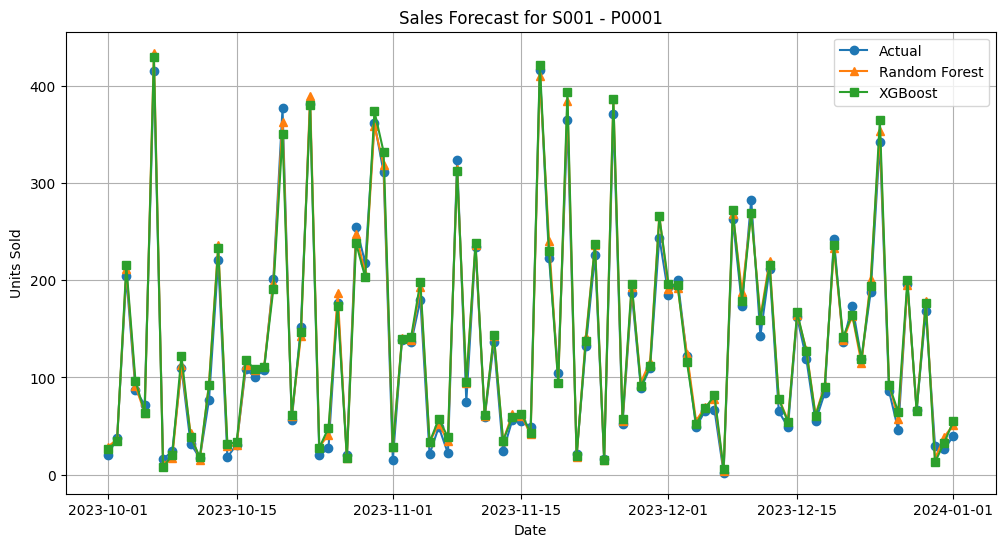

In [ ]:
# for an individual product and store

sample_store = 'S001'
sample_product = 'P0001'
sample_data = df[(df['Store ID']==sample_store) & (df['Product ID']==sample_product) & (df['Date'] >= test_start_date)]

X_sample_test = sample_data.drop(columns=['Date','Store ID','Product ID','Units Sold'])
y_sample_actual = sample_data['Units Sold']
y_sample_pred_rf = rf_model.predict(X_sample_test)
y_sample_pred_xgb = xgb_model.predict(X_sample_test)

plt.figure(figsize=(12,6))
plt.plot(sample_data['Date'], y_sample_actual, label='Actual', marker='o')
plt.plot(sample_data['Date'], y_sample_pred_rf, label='Random Forest', marker='^')
plt.plot(sample_data['Date'], y_sample_pred_xgb, label='XGBoost', marker='s')
plt.title(f'Sales Forecast for {sample_store} - {sample_product}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid()
plt.show()

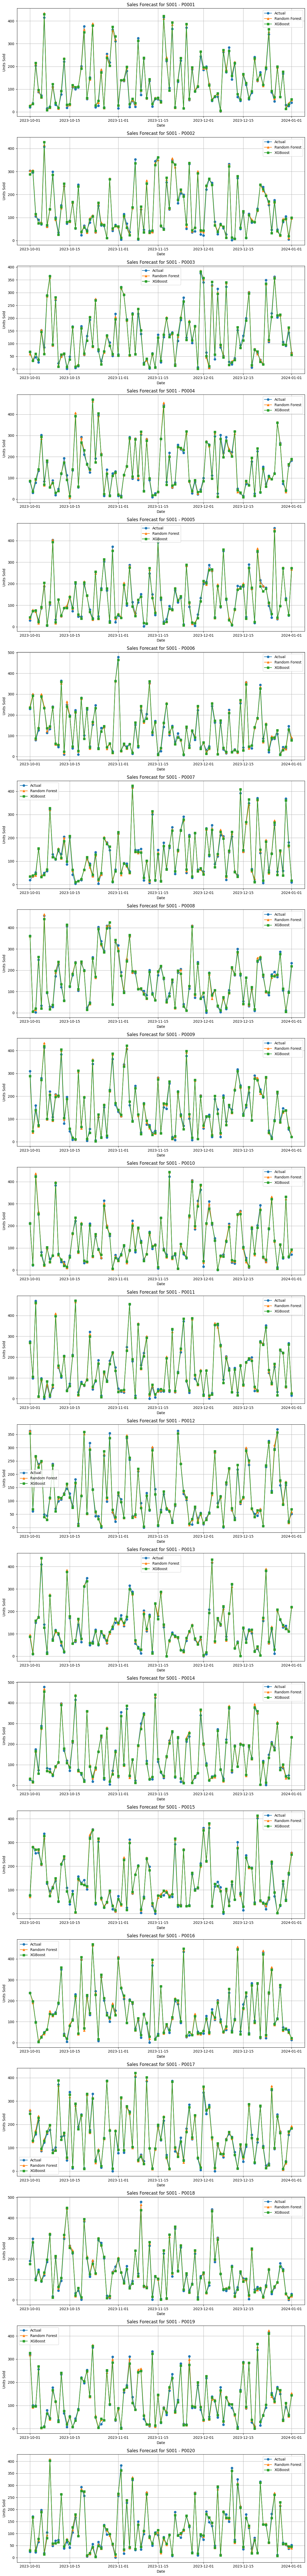

In [ ]:
# Select store S001
store_id = 'S001'

# Get unique products for this store
store_products = df[df['Store ID'] == store_id]['Product ID'].unique()

# Set up the plot configuration
num_products = len(store_products)
fig, axs = plt.subplots(num_products, 1, figsize=(12, 5*num_products))

if num_products == 1:
    axs = [axs]

for i, product in enumerate(store_products):
    sample_data = df[(df['Store ID'] == store_id) &
                     (df['Product ID'] == product) &
                     (df['Date'] >= test_start_date)].copy()

    # Prepare the test set exactly like training data
    X_sample_test = sample_data.drop(columns=['Date', 'Store ID', 'Product ID', 'Units Sold'])

    # Align columns to match training features
    missing_cols = set(X_train.columns) - set(X_sample_test.columns)
    extra_cols = set(X_sample_test.columns) - set(X_train.columns)

    # Add missing columns with default value 0
    for col in missing_cols:
        X_sample_test[col] = 0

    # Remove extra columns not used during training
    X_sample_test = X_sample_test[X_train.columns]

    # Actual units sold
    y_sample_actual = sample_data['Units Sold']

    # Predictions from trained models
    rf_preds = rf_model.predict(X_sample_test)
    xgb_preds = xgb_model.predict(X_sample_test)

    # Plotting
    axs[i].plot(sample_data['Date'], y_sample_actual, label='Actual', marker='o')
    axs[i].plot(sample_data['Date'], rf_preds, label='Random Forest', marker='^')
    axs[i].plot(sample_data['Date'], xgb_preds, label='XGBoost', marker='s')
    axs[i].set_title(f'Sales Forecast for {store_id} - {product}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Units Sold')
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()


In [ ]:
stores = df['Store ID'].unique()

for store_id in stores:
    products = df[df['Store ID'] == store_id]['Product ID'].unique()
    num_products = len(products)

    fig, axs = plt.subplots(num_products, 1, figsize=(12, 5 * num_products))
    fig.suptitle(f'Sales Forecasts for Store {store_id}', fontsize=16, y=1.02)

    if num_products == 1:
        axs = [axs]

    for i, product in enumerate(products):
        sample_data = df[(df['Store ID'] == store_id) &
                         (df['Product ID'] == product) &
                         (df['Date'] >= test_start_date)].copy()

        # Prepare test data exactly like training data
        X_sample_test = sample_data.drop(columns=['Date', 'Store ID', 'Product ID', 'Units Sold'])

        # Ensure columns match training data
        missing_cols = set(X_train.columns) - set(X_sample_test.columns)
        extra_cols = set(X_sample_test.columns) - set(X_train.columns)

        for col in missing_cols:
            X_sample_test[col] = 0

        X_sample_test = X_sample_test[X_train.columns]

        y_actual = sample_data['Units Sold']
        rf_preds = rf_model.predict(X_sample_test)
        xgb_preds = xgb_model.predict(X_sample_test)

        axs[i].plot(sample_data['Date'], y_actual, label='Actual', marker='o')
        axs[i].plot(sample_data['Date'], rf_preds, label='Random Forest', marker='^')
        axs[i].plot(sample_data['Date'], xgb_preds, label='XGBoost', marker='s')

        axs[i].set_title(f'Store: {store_id}, Product: {product}')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Units Sold')
        axs[i].legend()
        axs[i].grid()

    plt.tight_layout()
    plt.show()
